In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [20]:
# --- Configuration ---
base_dir = 'civic_issue_dataset'

# --- Script to find bad files ---
print("Scanning for corrupted or invalid images...")
for root, dirs, files in os.walk(base_dir):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(root, filename)
            try:
                with Image.open(filepath) as img:
                    img.verify()
            except Exception as e:
                print(f"Problem file found: {filepath}")
                print(f"   Error: {e}\n")

print(" Scan complete. Please delete any problem files listed above.")

Scanning for corrupted or invalid images...
✅ Scan complete. Please delete any problem files listed above.


In [21]:
# --- Configuration ---
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

img_height, img_width = 128, 128
batch_size = 32

# --- Data Augmentation & Loading ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# --- Get Class Labels ---
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(f"Found {train_generator.samples} training images belonging to {num_classes} classes.")
print(f"Found {validation_generator.samples} validation images.")
print("Class Labels:", class_labels)

Found 6607 images belonging to 6 classes.
Found 320 images belonging to 6 classes.
✅ Found 6607 training images belonging to 6 classes.
✅ Found 320 validation images.
Class Labels: ['broken_streetlight', 'electric_pole_damage', 'flood_waterlogging', 'garbage', 'open_manhole', 'pothole']


In [22]:
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

# CNN Feature Extractor
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Prepare for RNN
reshaped = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)

# RNN Classifier
x = LSTM(128, return_sequences=False)(reshaped)
x = Dropout(0.5)(x)

# Final Dense Layer
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,208,646 (4.61 MB)

 Trainable params: 1,208,646 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# --- Training Parameters ---
epochs = 25 # Increase if needed, e.g., to 50

# --- Start Training ---
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    # Adjust steps if you have a very large dataset, otherwise it's fine
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_steps=max(1, validation_generator.samples // batch_size)
)

Epoch 1/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 245ms/step - accuracy: 0.5869 - loss: 1.0862 - val_accuracy: 0.8281 - val_loss: 0.6528
Epoch 2/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.6504 - val_accuracy: 0.8406 - val_loss: 0.6490
Epoch 3/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - accuracy: 0.7227 - loss: 0.7666 - val_accuracy: 0.6750 - val_loss: 1.0098
Epoch 4/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.7722 - val_accuracy: 0.6781 - val_loss: 0.9952
Epoch 5/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.7792 - loss: 0.6262 - val_accuracy: 0.8219 - val_loss: 0.6014
Epoch 6/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.5068 - val_accuracy: 0.8156 - val_loss: 0.6258
Epoch 7/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.7947 - loss: 0.5712 - val_accuracy: 0.7031 - val_loss: 0.8630
Epoch 8/25
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7812 - loss: 0.6688 - val_

In [34]:
# Save the entire model to a single HDF5 file.
model.save('civic_issue_image_model.h5')

print("Image model saved successfully as civic_issue_image_model.h5")

✅ Image model saved successfully as civic_issue_image_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


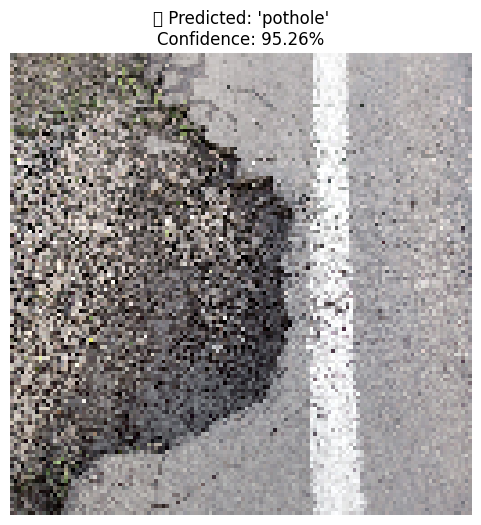

In [32]:
# Import necessary libraries for image processing
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION: CORRECTED FILE PATH ---
# The path is relative to your notebook in the 'model' folder
image_path = "C:/Users/SWARNABHA/Desktop/Crowdsourced/pothole/pothole8.jpg"

# --- 2. LOAD AND PREPROCESS THE IMAGE ---
# Load the image, ensuring the target_size matches the model's input size
img = image.load_img(image_path, target_size=(img_height, img_width))

# Convert the image to a NumPy array and normalize it
img_array = image.img_to_array(img)
img_array /= 255.0

# The model expects a "batch" of images, so we add an extra dimension
image_batch = np.expand_dims(img_array, axis=0)

# --- 3. MAKE THE PREDICTION ---
# Use the trained model to predict the class of the image
prediction = model.predict(image_batch)

# Find the class with the highest probability
predicted_class_index = np.argmax(prediction[0])

# Get the corresponding label from the class_labels list we defined earlier
predicted_label = class_labels[predicted_class_index]
confidence = np.max(prediction[0]) * 100

# --- 4. DISPLAY THE RESULT ---
# Show the image and print the model's prediction
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Predicted: '{predicted_label}'\nConfidence: {confidence:.2f}%")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
✅ Classification Result:
   - Predicted Issue: 'pothole'
   - Confidence: 95.26%


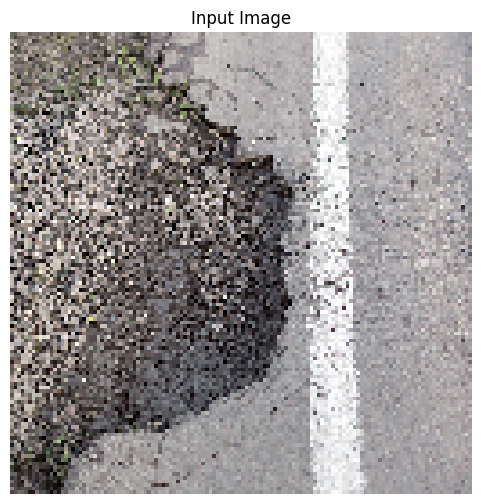

In [33]:
# Import necessary libraries for image processing
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION: CORRECTED FILE PATH ---
# The path is relative to your notebook in the 'model' folder
image_path = "C:/Users/SWARNABHA/Desktop/Crowdsourced/pothole/pothole8.jpg"

# --- 2. LOAD AND PREPROCESS THE IMAGE ---
# Load the image, ensuring the target_size matches the model's input size
img = image.load_img(image_path, target_size=(img_height, img_width))

# Convert the image to a NumPy array and normalize it
img_array = image.img_to_array(img)
img_array /= 255.0

# The model expects a "batch" of images, so we add an extra dimension
image_batch = np.expand_dims(img_array, axis=0)

# --- 3. MAKE THE PREDICTION ---
# Use the trained model to predict the class of the image
prediction = model.predict(image_batch)

# Find the class with the highest probability
predicted_class_index = np.argmax(prediction[0])

# Get the corresponding label from the class_labels list we defined earlier
predicted_label = class_labels[predicted_class_index]
confidence = np.max(prediction[0]) * 100


# --- 4. DISPLAY THE RESULT IN TWO SECTIONS ---

# --- Section 1: Displaying the text output ---
print("Classification Result:")
print(f"   - Predicted Issue: '{predicted_label}'")
print(f"   - Confidence: {confidence:.2f}%")

# --- Section 2: Displaying the image ---
# Show the image in a separate window without the prediction text as the title
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Input Image") # Add a simple title for the image window
plt.axis('off') # Keep the axes off for a cleaner look
plt.show()